# Test pipeline
1. Create dataset: sequence of preporcessed examples ready to feed to neuralnet 
2. Create dataloader: define how dataset is loaded to neuralnet (batch size, order, computation optimizing ...)
3. Create model : a bunch of matrixes math to transform input tensor to output tensor
4. Training loop:
    + Forward 
    + Calculate loss
    + Backward
    + Monitoring: 
        + Evaluate metrics
        + Logger, back and forth
        + Visualize

# Import necessary packages

In [1]:

import os
import glob
import sys
import random

import matplotlib.pylab as plt
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

import numpy as np

from sklearn.model_selection import ShuffleSplit




torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%matplotlib inline


sys.path.insert(0, '..')
from src.models.utils import FaceDataset
from src.models.experiment import Experiment


# Create a transformer

In [2]:

def resize_img_label(image,label,target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    return image_new,label

def transformer(image, label, params):
    image,label = resize_img_label(image,label,params["target_size"]) 
    image = TF.to_tensor(image)
    return image, label



# Create Data loader

In [3]:
trans_params_train = {
    "target_size" : (256, 256),
}


trans_params_val={
    "target_size" : (256, 256), 
}

path2data = "/home/Data/appa-real/processed/"



In [4]:
# create data set
train_ds = FaceDataset(path2data + "train.csv", transformer, trans_params_train)
val_ds = FaceDataset(path2data + "valid.csv", transformer, trans_params_val)

print(len(train_ds))
print(len(val_ds))

3995
1500


In [5]:
import matplotlib.pyplot as plt
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

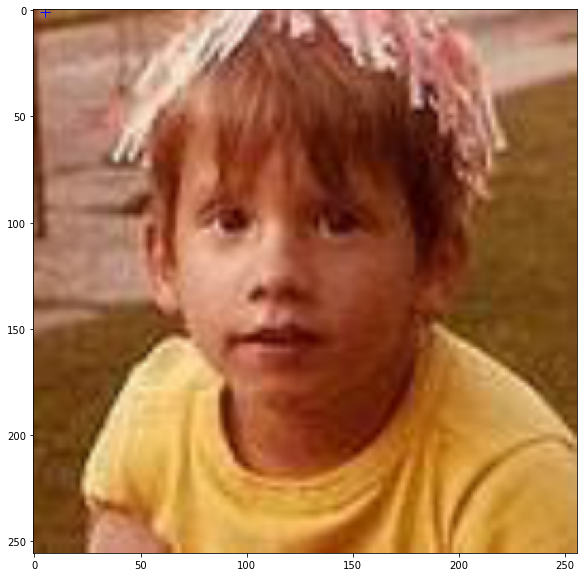

In [6]:

plt.figure(figsize=(10,10))
for img,label in train_ds:
    show(img,label)
    break

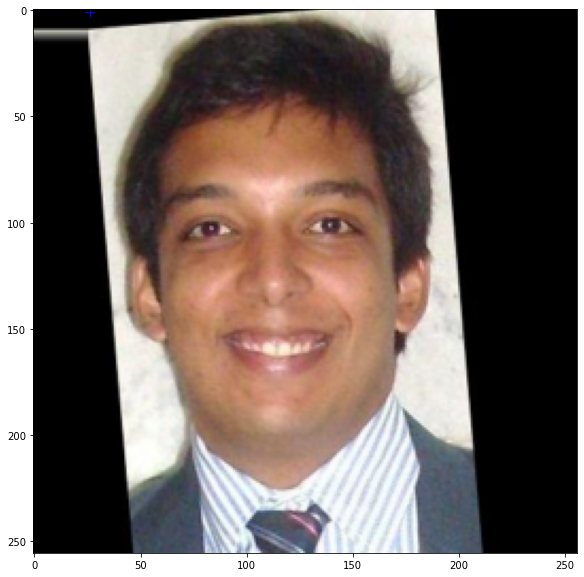

In [7]:
plt.figure(figsize=(10,10))
for img,label in val_ds:
    show(img,label)
    break

In [8]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 128, shuffle=False)

In [9]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([32, 3, 256, 256]) torch.float32
torch.Size([32, 2])


In [10]:
for img, label in val_dl:
    print(label.shape)
    break

torch.Size([128, 2])



# Create Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F


In [12]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [13]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)

In [14]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x


In [15]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16, 
        "num_outputs": 1,
            }

model = Net(params_model)
device = torch.device("cuda")
model=model.to(device)

# Create optimizer

In [16]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)



In [17]:
class Performance:
    def __init__(self):
        # history of loss values in each epoch
        self.loss_history={
            "train": [],
            "val": [],
        }
    
        # histroy of metric values in each epoch
        self.metric_history={
            "val": [],
        }
        
        self.epoch = 0
        self.avg_loss = 0.0
        self.avg_metric = 0.0
        self.count = 0
        self.loss_sum = 0
        self.metric_sum = 0
        self.loss = nn.MSELoss(reduction="sum")
        
    
    def loss_function(self, predictions, targets):
        loss = self.loss(predictions, targets[:, 0])
        self.loss_sum = self.loss_sum + loss.item()
        self.count = self.count + len(predictions)          
        return loss

    def metrics_function(self, predictions, targets):
        mae = torch.abs(predictions - targets[:, 0]).sum()
        self.metric_sum = self.loss_sum + mae.item()
        self.count = self.count + len(predictions) 
        
        return mae
        
    def log(self, training):
        if training:
            self.avg_loss = self.loss_sum/self.count
            # collect loss and metric for training dataset
            self.loss_history["train"].append(self.avg_loss)
        else:
            self.avg_loss = self.loss_sum/self.count
            # collect loss and metric for training dataset
            self.loss_history["val"].append(self.avg_loss)
            
            self.avg_metrics = self.metric_sum/self.count
            # collect loss and metric for training dataset
            self.metric_history["val"].append(self.avg_metrics)
            
        self.count = 0
        self.loss_sum = 0
        self.metric_sum = 0


In [18]:
from src.models import experiment

performance = Performance()

path2models= "../models/weights.pt"
params = experiment.Prams(num_epochs= 100, path2weights=path2models)

iteration = experiment.Iteration(optimizer=opt, lr_scheduler=lr_scheduler)

learning_procedure = experiment.LearningProcedure(iteration=iteration, performance = performance, params=params)

experiment = experiment.Experiment(train_dl, val_dl, model, learning_procedure, device, True)

# Training

In [19]:
model, performance = experiment.run()



Epoch 0/99, current lr=0.001


/home/duc/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/duc/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Copied best model weights!
Epoch 1/99, current lr=0.001
Copied best model weights!
Epoch 2/99, current lr=0.001
Copied best model weights!
Epoch 3/99, current lr=0.001
Copied best model weights!
Epoch 4/99, current lr=0.001
Copied best model weights!
Epoch 5/99, current lr=0.001
Copied best model weights!
Epoch 6/99, current lr=0.001
Epoch 7/99, current lr=0.001
Epoch 8/99, current lr=0.001
Epoch 9/99, current lr=0.001
Copied best model weights!
Epoch 10/99, current lr=0.001
Copied best model weights!
Epoch 11/99, current lr=0.001
Epoch 12/99, current lr=0.001
Epoch 13/99, current lr=0.001
Epoch 14/99, current lr=0.001
Epoch 15/99, current lr=0.001
Epoch 16/99, current lr=0.001
Epoch 17/99, current lr=0.001
Copied best model weights!
Epoch 18/99, current lr=0.001
Copied best model weights!
Epoch 19/99, current lr=0.001
Epoch 20/99, current lr=0.001
Epoch 21/99, current lr=0.001
Epoch 22/99, current lr=0.001
Epoch 23/99, current lr=0.001
Copied best model weights!
Epoch 24/99, current l

In [22]:
loss_hist, metric_history = performance.loss_history, performance.metric_history

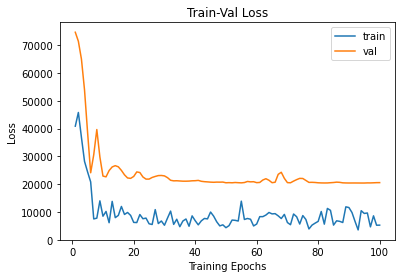

In [25]:
# Train-Validation Progress
num_epochs= 100

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_history["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_history["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()